## Download All Models

In [1]:
!pip install xgboost==0.90
!pip install eli5

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
from get_model import get_model_weights
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score
from utils import print_f1_scores, cause_for_code_refinement
import pandas as pd
import os
import numpy as np
import xgboost
import warnings
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Loading the refined test set:

In [3]:
data_dir = 'wildfire_data'
test_x = pd.read_csv(os.path.join(data_dir, 'test_ref.csv'), header=None)
test_y = pd.read_csv(os.path.join(data_dir, 'test_ref_y.csv'), header=None)

Model locations from buckets:

In [4]:
model_linear_data_path = "s3://sagemaker-us-west-1-170667047098/wildfire/linear-learner-2021-02-07-06-54-15-448/output/model.tar.gz"
dest_linear = "model_linear.tar.gz"
method_linear = 'mxnet'

model_mlp_data_path = "s3://sagemaker-us-west-1-170667047098/sagemaker-scikit-learn-2021-02-07-05-50-43-359/output/model.tar.gz"
dest_mlp = "model_mlp.tar.gz"
method_mlp = 'joblib'

model_xgb_data_path = "s3://sagemaker-us-west-1-170667047098/wildfire/output/xgboost-210204-0337-003-5835143b/output/model.tar.gz"
dest_xgb = "model_xgb.tar.gz"
method_xgb = 'pickle'

model_mlp_ref_data_path = "s3://sagemaker-us-west-1-170667047098/sagemaker-scikit-learn-2021-02-10-04-55-57-612/output/model.tar.gz"
dest_mlp_ref = "model_mlp_ref.tar.gz"

In [5]:
models_info = [(model_linear_data_path, dest_linear, method_linear), 
              (model_mlp_ref_data_path, dest_mlp_ref, method_mlp), 
              (model_xgb_data_path, dest_xgb, method_xgb)]

loaded_models = [get_model_weights(model_info[0], model_info[1], model_info[2]) for model_info in models_info]
loaded_linear_model = loaded_models[0]
loaded_mlp_ref_model = loaded_models[1]
loaded_xgb_model = loaded_models[2]

### Replicate Refined MLP Model Results Locally

All the work that follows is for the refined MLP model with 6 target classes.

In [6]:
prediction_batches = [loaded_mlp_ref_model.predict(batch) for batch in np.array_split(test_x, 100)]
test_y_preds = np.concatenate([batch for batch in prediction_batches])
accuracy_mlp = accuracy_score(test_y, test_y_preds)
f1_score_mlp = f1_score(test_y, test_y_preds, average=None)
df_f1_score_mlp = print_f1_scores(f1_score_mlp, cause_for_code_refinement)
print(f"Accuracy for MLP refined model is {accuracy_mlp}")
df_f1_score_mlp

Accuracy for MLP refined model is 0.40956052320009023


,Causes Description,F1 scores
0,Lightning,0.621717
1,Debris Burning,0.523913
2,Arson,0.266126
3,Miscellaneous,0.389600
4,Missing/Undefined,0.096244
5,Other,0.272116


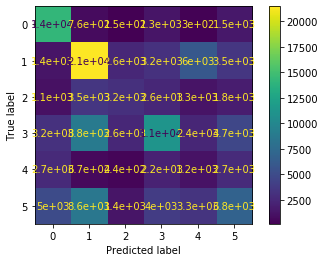

In [7]:
plot_confusion_matrix(loaded_mlp_ref_model, test_x, test_y)

## Refined Model Interpretability

In [8]:
import eli5

Using MXNet backend


In [9]:
perm = eli5.sklearn.PermutationImportance(loaded_mlp_ref_model).fit(test_x, test_y)

In [53]:
with open(os.path.join("wildfire_data", "feature_names.pkl"), "rb") as file:
    feature_names = pickle.load(file)
eli5.show_weights(perm, top = test_x.shape[1], feature_names = feature_names)

Weight,Feature
0.0619 ± 0.0009,TX
0.0532 ± 0.0013,DISCOVERY_DOY_COS
0.0433 ± 0.0011,NY
0.0397 ± 0.0009,FIRE_SIZE
0.0333 ± 0.0011,GA
0.0286 ± 0.0006,Night
0.0274 ± 0.0013,Afternoon
0.0225 ± 0.0011,DISCOVERY_DOY_SIN
0.0191 ± 0.0012,CA
0.0149 ± 0.0004,Morning


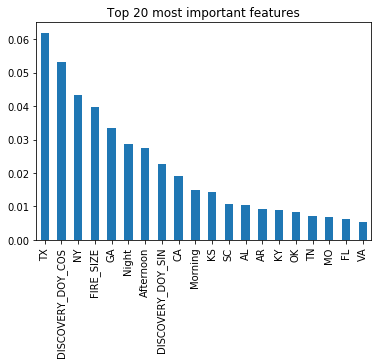

In [68]:
pd.Series(perm.feature_importances_, index = feature_names).nlargest(20).plot.bar()
plt.title("Top 20 most important features")
plt.show()

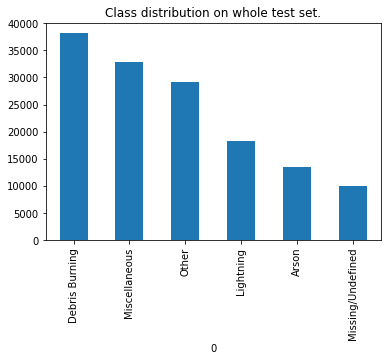

In [88]:
test_y_labels = test_y[0].map(cause_for_code_refinement)
test_y_labels.groupby(test_y_labels).size().sort_values(ascending = False).plot.bar()
plt.title("Class distribution on whole test set.")
plt.show()

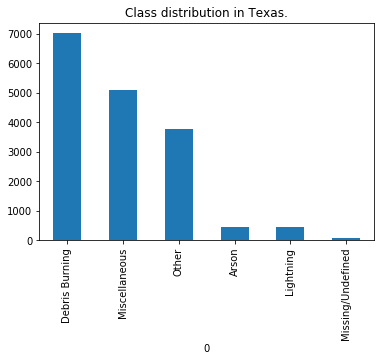

In [104]:
test_y_labels_texas = test_y_labels[test_x[feature_names.index('TX')] == 1]
test_y_labels_texas.groupby(test_y_labels_texas).size().sort_values(ascending = False).plot.bar()
plt.title("Class distribution in Texas.")
plt.show()

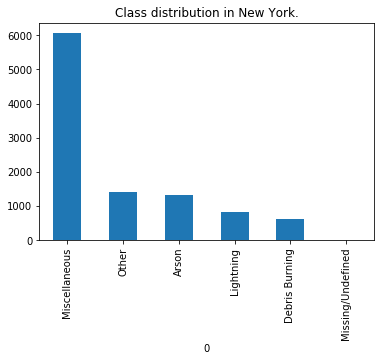

In [105]:
test_y_labels_texas = test_y_labels[test_x[feature_names.index('NY')] == 1]
test_y_labels_texas.groupby(test_y_labels_texas).size().sort_values(ascending = False).plot.bar()
plt.title("Class distribution in New York.")
plt.show()

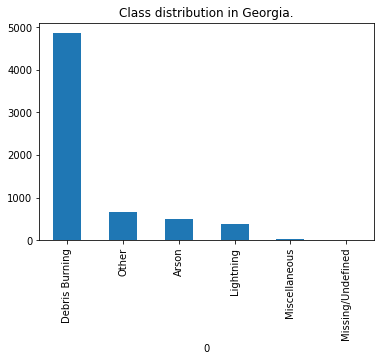

In [106]:
test_y_labels_texas = test_y_labels[test_x[feature_names.index('GA')] == 1]
test_y_labels_texas.groupby(test_y_labels_texas).size().sort_values(ascending = False).plot.bar()
plt.title("Class distribution in Georgia.")
plt.show()

In [110]:
pd.DataFrame({'FIRE_SIZE': test_x[feature_names.index('FIRE_SIZE')], 'CLASS': test_y_labels}).set_index('CLASS').unstack().head()

           CLASS    
FIRE_SIZE  Lightning   -2.302585
           Lightning   -2.302585
           Lightning   -2.302585
           Lightning   -2.302585
           Lightning   -2.302585
dtype: float64